In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First we'll generate a random matrix

In [2]:
#Number of columns (features)
K = 5

#Number of records
N = 1000

#Generate an NxK matrix of uniform random variables
X = np.random.rand(N,K) #Student: generate a uniform random matrix here
X

array([[0.22742904, 0.57962491, 0.8965079 , 0.10242142, 0.05595762],
       [0.0281389 , 0.01771646, 0.40027633, 0.00524244, 0.88807334],
       [0.0322476 , 0.35567049, 0.44890969, 0.35131625, 0.81722062],
       ...,
       [0.72877103, 0.05328369, 0.19941721, 0.97411206, 0.70197796],
       [0.74621093, 0.06750039, 0.37102847, 0.92372285, 0.13211221],
       [0.69818243, 0.26430783, 0.33722295, 0.97019887, 0.4315765 ]])

Let's peak at our data to confirm it looks as we expect it

In [3]:
#Student - Put in a command to view the first 100 rows
X[:100]

array([[2.27429044e-01, 5.79624912e-01, 8.96507899e-01, 1.02421422e-01,
        5.59576194e-02],
       [2.81388959e-02, 1.77164590e-02, 4.00276330e-01, 5.24244442e-03,
        8.88073343e-01],
       [3.22475954e-02, 3.55670491e-01, 4.48909692e-01, 3.51316248e-01,
        8.17220618e-01],
       [6.83644264e-01, 2.77116048e-01, 5.24008044e-01, 3.26497426e-01,
        3.24269661e-01],
       [8.59845249e-01, 4.52034360e-01, 2.65658815e-01, 9.94087710e-01,
        7.14569879e-01],
       [1.50116569e-01, 3.46851572e-01, 2.97327629e-01, 5.19546504e-01,
        9.35812101e-01],
       [8.00245645e-01, 6.77039949e-02, 2.00623248e-01, 4.04774722e-01,
        9.44982471e-01],
       [9.60170292e-01, 7.56754735e-01, 8.88962179e-01, 4.40277043e-01,
        6.87317670e-01],
       [2.49591310e-01, 5.05388096e-01, 9.77365987e-01, 1.85856553e-01,
        7.06534374e-01],
       [2.08887814e-01, 6.46725787e-01, 3.03843631e-01, 5.60415677e-01,
        5.41510823e-01],
       [6.82343067e-01, 9.9814

In [4]:
#Student - put in a command to see the dimensions of X
X.shape

(1000, 5)

This exercise is about designing a scoring function for a logistic regression. As we are not concerned with fitting a model to data, we can just make up a logistic regression. <br> <br>

For quick intro, the Logistic Regression takes the form of $\hat{Y} = f(x * \beta^T)$, where $x$ is the $1xK$ vector of features and $\beta$ is the $1xK$ vector of weights. The function $f$, called a 'link' function, is the inverse logit: <br><br>

<center>$f(a)=\frac{1}{1+e^{-a}}$</center> <br><br>

In this notebook we'll write a function that, given inputs of $X$ and $\beta$, returns a value for $\hat{Y}$.
<br><br>
First let's generate a random set of weights to represent $\beta$.


In [13]:
#Student - generate a K dimensional vector of uniform random variables in the interval [-1, 1]
beta = 2*np.random.rand(K) - 1
beta

array([ 0.61274379, -0.72897367, -0.04410014,  0.94880048,  0.06041843])

Notice how we applied a neat NumPy trick here. The numpy.random.random() function returns an array, yet we applied what appears to be a scalar operation on the vector. This is an example of what NumPy calls vectorization (a major point of this tutorial), which offers us both a very fast way to do run vector computations as well as a clean and concise method of coding. 

<br><br>

<b>Question: we designed the above $beta$ vector such that $E[\beta_i]=0$. How can we confirm that we did this correctly?</b>

In [14]:
#start by taking the mean of the beta we already calculated

#Student - fill in command here

beta.mean()

0.16977777695866564

In [15]:
#It is likely the above is not equal to zero. Let's simulate this 100k times and see what the distribution of means is
#Student input code here
means = [(2*np.random.rand(K)-1).mean() for i in range(100000)]

Now let's use matplotlibs hist function to plot the histogram of means here. 

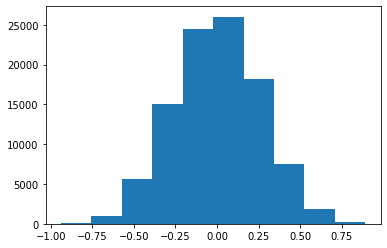

In [16]:
plt.hist(means)
plt.show()

We should expect the distribution to be centered around zero. Is it? As fun technical side, let's dive a little deeper into what this distribution should look like. The histogram shows a distribution of the average of a sample of 5 uniformly distributed random variables taken over N different samples. Can we compare this to a theoretical distribution?<br>

Yes we can! We sampled each $\beta_i$ from a uniform distribution over the interval $[-1, 1]$. The variance of a sample of uniformly distributed variables is given by $(1/12) * (b - a)^2$, where $b$ and $a$ are the min/max of the support interval. The standard error (or the standard deviation of the mean) of a sample of size K with with $Var(X) = \sigma^2$ is $\sigma / \sqrt(K)$. <br>

Given the above knowledge, we should expect our distribution of averages to be normally distributed with mean = 0 and var = $(12 * 5)^{-1} * (1 - (-1))^2 = 0. 66667$. Let's compare this normal distribution to our sample above.

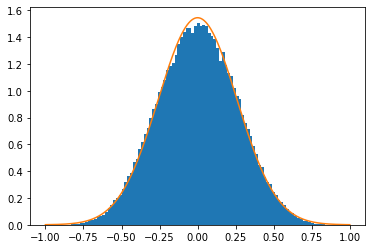

In [28]:
#Compute a vector from the normal distribution specified above
from scipy.stats import norm
mu = 0
sig = np.sqrt(4 / 60.0) 
xs = np.linspace(-1, 1, 1000)
ys = norm.pdf(xs, mu, sig) 

plt.hist(means, bins=100, density=True)
plt.plot(xs, ys)
plt.show()


Now let's write our scoring function. Let's try to use as much of Numpy's inner optimization as possible (hint, this can be done in two lines and without writing any loops). The key is that numpy functions that would normally take in a scalar can also take in an array, and the function applies the operations element wise to the array and returns an array. i.e.:

In [29]:
ex_array = np.array([-1, 1])
np.abs(ex_array)

array([1, 1])

Let's use this feature to write a fast and clean scoring function

In [30]:
def score_logistic_regression(X, beta):
    '''
    This function takes in an NxK matrix X and 1xK vector beta.
    The function should apply the logistic scoring function to each record of X.
    The output should be an Nx1 vector of scores
    '''
    
    #First let's calculate X*beta - make sure to use numpy's 'dot' method
    a = X.dot(beta)
    
    #Now let's input this into the link function
    prob_score = 1 / (1 + np.exp(-a))
    
    return prob_score

So how much faster is it by using Numpy? We can test this be writing the same function that uses no Numpy and executes via loops.

In [37]:
from math import exp

def score_logistic_regression_NoNumpy(X, beta):
    '''
    This function takes in an NxK matrix X and 1xK vector beta.
    The function should apply the logistic scoring function to each record of X.
    The output should be an Nx1 vector of scores
    '''
    #Let's calculate xbeta using loops
    xbeta = []
    for row in X:
        
        xb = 0
        for i, el in enumerate(row):
            #Student - compute X*Beta in the loop
            xb += el * beta[i]
        
        xbeta.append(xb)
        
    #Now let's apply the link function to each xbeta
    prob_score = []
    for xb in xbeta:
        #student - compute p in the loop
        p = 1 / (1 + exp(-xb))
        prob_score.append(p)
        
    return prob_score

Before doing any analysis, let's test the output of each to make sure they equal

In [39]:
#Student - write a unit test that calls each function with the same inputs and checks to see they return the same values. 
def test_methods(X, beta):
    return all(np.isclose(score_logistic_regression(X, beta), score_logistic_regression_NoNumpy(X,beta)))

test_methods(X,beta)

True

If they equal then we can proceed with timing analysis

In [40]:
%timeit score_logistic_regression_NoNumpy(X, beta)

3.54 ms ± 74.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%timeit score_logistic_regression(X, beta)

19.4 µs ± 49.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
